In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint # type: ignore #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model # type: ignore #tải mô hình
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore

#các lớp để xây dựng mô hình
from keras.models import Sequential # type: ignore #đầu vào
from keras.layers import LSTM # type: ignore #học phụ thuộc
from keras.layers import Dropout # type: ignore #tránh học tủ
from keras.layers import Dense # type: ignore #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score  # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error  # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error, f1_score  # Đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

In [2]:

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  
collection = db['HDB']  

# Chuyển dữ liệu thành DataFrame
df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
df


,Ngay,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
0,2018-01-05,11.74,39.60,32205910,1.239286e+12,0,0.000000e+00,39.00,39.60,36.50,6.60,20.00
1,2018-01-08,11.77,39.70,3321420,1.318970e+11,15320003,5.686017e+11,40.00,40.00,39.60,0.10,0.25
2,2018-01-09,11.79,39.75,4537340,1.794370e+11,5451600,2.112977e+11,39.70,39.80,38.90,0.05,0.13
3,2018-01-10,11.95,40.30,8726070,3.468570e+11,3110000,1.240810e+11,39.20,40.30,39.10,0.55,1.38
4,2018-01-11,12.60,42.50,9874500,4.097550e+11,1110003,4.627011e+10,40.40,42.50,40.30,2.20,5.46
...,...,...,...,...,...,...,...,...,...,...,...,...
1722,2024-12-02,25.40,25.40,5374800,1.365440e+11,1988000,5.039580e+10,25.40,25.50,25.25,0.05,0.20
1723,2024-12-03,26.05,26.05,11353100,2.932140e+11,4782000,1.214498e+11,25.90,26.15,25.60,0.65,2.56
1724,2024-12-04,25.90,25.90,6699700,1.737480e+11,3156000,8.221380e+10,26.05,26.15,25.80,-0.15,-0.58
1725,2024-12-05,26.70,26.70,9434400,2.477530e+11,2195000,5.675040e+10,25.95,26.70,25.90,0.80,3.09


In [3]:
# Kiểm tra dữ liệu
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               1727 non-null   object 
 1   GiaDieuChinh       1727 non-null   float64
 2   GiaDongCua         1727 non-null   float64
 3   KhoiLuongKhopLenh  1727 non-null   int64  
 4   GiaTriKhopLenh     1727 non-null   float64
 5   KLThoaThuan        1727 non-null   int64  
 6   GtThoaThuan        1727 non-null   float64
 7   GiaMoCua           1727 non-null   float64
 8   GiaCaoNhat         1727 non-null   float64
 9   GiaThapNhat        1727 non-null   float64
 10  ThayDoi_GiaTri     1727 non-null   float64
 11  ThayDoi_PhanTram   1727 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 162.0+ KB


,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
count,1727.000000,1727.000000,1.727000e+03,1.727000e+03,1.727000e+03,1.727000e+03,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000
mean,14.236914,26.699334,3.591060e+06,9.374803e+10,1.377404e+06,3.243802e+10,26.689548,27.026578,26.304314,0.006288,0.046665
std,5.220229,6.783613,2.913946e+06,8.190322e+10,3.289792e+06,7.526164e+10,6.776770,6.891858,6.653186,0.642377,2.175715
min,5.300000,14.000000,2.991900e+05,8.405000e+09,0.000000e+00,0.000000e+00,13.350000,14.500000,13.050000,-6.950000,-20.770000
25%,9.370000,23.000000,1.480300e+06,3.666700e+10,0.000000e+00,0.000000e+00,23.000000,23.350000,22.675000,-0.200000,-0.870000
50%,13.790000,26.250000,2.423900e+06,6.336800e+10,5.000000e+04,1.112000e+09,26.250000,26.450000,25.950000,0.000000,0.000000
75%,17.040000,29.500000,5.341550e+06,1.340580e+11,1.000000e+06,2.457964e+10,29.400000,29.875000,29.025000,0.250000,0.970000
max,28.300000,51.800000,3.220591e+07,1.239286e+12,3.057690e+07,6.993515e+11,51.900000,52.400000,50.600000,6.600000,20.000000


In [5]:
# Xử lý thời gian và sắp xếp dữ liệu
df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
df = df.sort_values(by='Ngay')

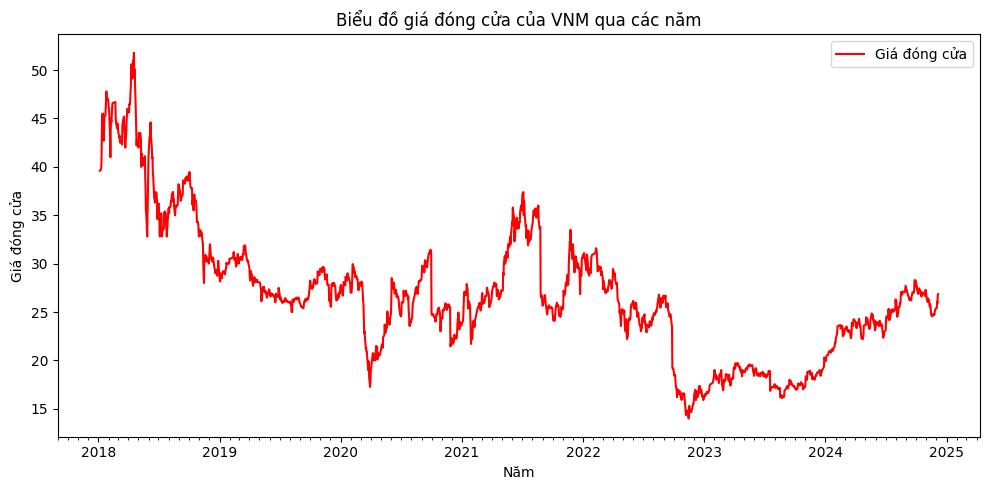

In [6]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Lấy thông tin năm từ cột "Ngày"
df['Nam'] = df['Ngay'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của VNM qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [7]:
# Chuyển đổi sang chỉ số thời gian
df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
df1.index = df1['Ngay']
df1.drop('Ngay', axis=1, inplace=True)

In [8]:
df1

,GiaDongCua
Ngay,
2018-01-05,39.60
2018-01-08,39.70
2018-01-09,39.75
2018-01-10,40.30
2018-01-11,42.50
...,...
2024-12-02,25.40
2024-12-03,26.05
2024-12-04,25.90


In [9]:
# Chia tập dữ liệu
data = df1.values
train_data = data[:int(len(df) * 0.8)]
test_data = data[int(len(df) * 0.8):]

In [10]:
data

array([[39.6 ],
       [39.7 ],
       [39.75],
       ...,
       [25.9 ],
       [26.7 ],
       [26.85]])

In [11]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [12]:
# Tạo cửa sổ thời gian cho tập train
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [13]:
# Tạo cửa sổ thời gian cho tập test
x_test, y_test = [], []
for i in range(50, len(test_data)):
    x_test.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_test.append(sc_train[i, 0])  # Giá trị tiếp theo
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

C:\Users\TRUONG\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100

Epoch 1: loss improved from inf to 0.21896, saving model to save_models/HDB_model.keras
21/21 - 6s - 265ms/step - loss: 0.2190 - val_loss: 0.1508
Epoch 2/100

Epoch 2: loss improved from 0.21896 to 0.13215, saving model to save_models/HDB_model.keras
21/21 - 1s - 56ms/step - loss: 0.1322 - val_loss: 0.1024
Epoch 3/100

Epoch 3: loss improved from 0.13215 to 0.11156, saving model to save_models/HDB_model.keras
21/21 - 1s - 53ms/step - loss: 0.1116 - val_loss: 0.0857
Epoch 4/100

Epoch 4: loss improved from 0.11156 to 0.09674, saving model to save_models/HDB_model.keras
21/21 - 1s - 53ms/step - loss: 0.0967 - val_loss: 0.0753
Epoch 5/100

Epoch 5: loss improved from 0.09674 to 0.08524, saving model to save_models/HDB_model.keras
21/21 - 1s - 55ms/step - loss: 0.0852 - val_loss: 0.0679
Epoch 6/100

Epoch 6: loss improved from 0.08524 to 0.08261, saving model to save_models/HDB_model.keras
21/21 - 1s - 53ms/step - loss: 0.0826 - val_loss: 0.0685
Epoch 7/100

Epoch 7: loss impr

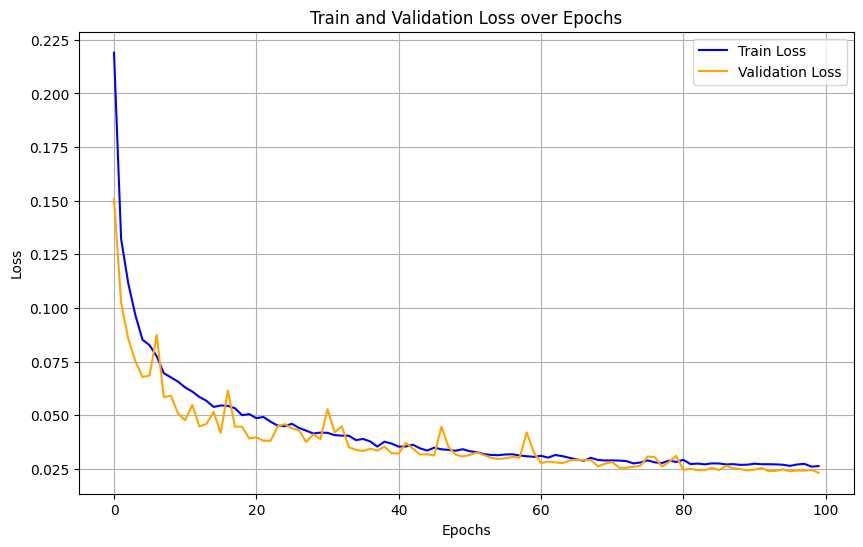

In [13]:
def build_model(input_shape):
    model = Sequential()
    
    # Giảm số đơn vị trong LSTM và tăng regularization
    model.add(LSTM(units=64, input_shape=input_shape, return_sequences=True, 
                   kernel_regularizer=l2(0.001)))
    model.add(LSTM(units=32, kernel_regularizer=l2(0.001)))
    
    # Tăng Dropout để giảm overfitting
    model.add(Dropout(0.4))
    
    # Lớp Dense để đưa ra kết quả dự đoán
    model.add(Dense(1))
    
    # Compile mô hình
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001))
    return model

# Xây dựng mô hình
input_shape = (x_train.shape[1], x_train.shape[2])
model = build_model(input_shape)

# Đường dẫn lưu mô hình
save_model_path = "save_models/HDB_model.keras"

# Callbacks: ModelCheckpoint và EarlyStopping
callbacks = [
    ModelCheckpoint(save_model_path, monitor='loss', verbose=2, save_best_only=True, mode='auto'),
    EarlyStopping(monitor='loss', patience=15, restore_best_weights=True, verbose=2)
]

# Huấn luyện mô hình và lưu kết quả vào history
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),  # Thêm tập validation
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=callbacks
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')  # Thêm val_loss
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
save_model_path = "save_models/HDB_model.keras"
# Tải mô hình tốt nhất
final_model = load_model(save_model_path)

In [15]:
# Dự đoán trên tập train
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)
y_train = sc.inverse_transform(y_train.reshape(-1, 1))

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


In [16]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[int(len(df) * 0.8):] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


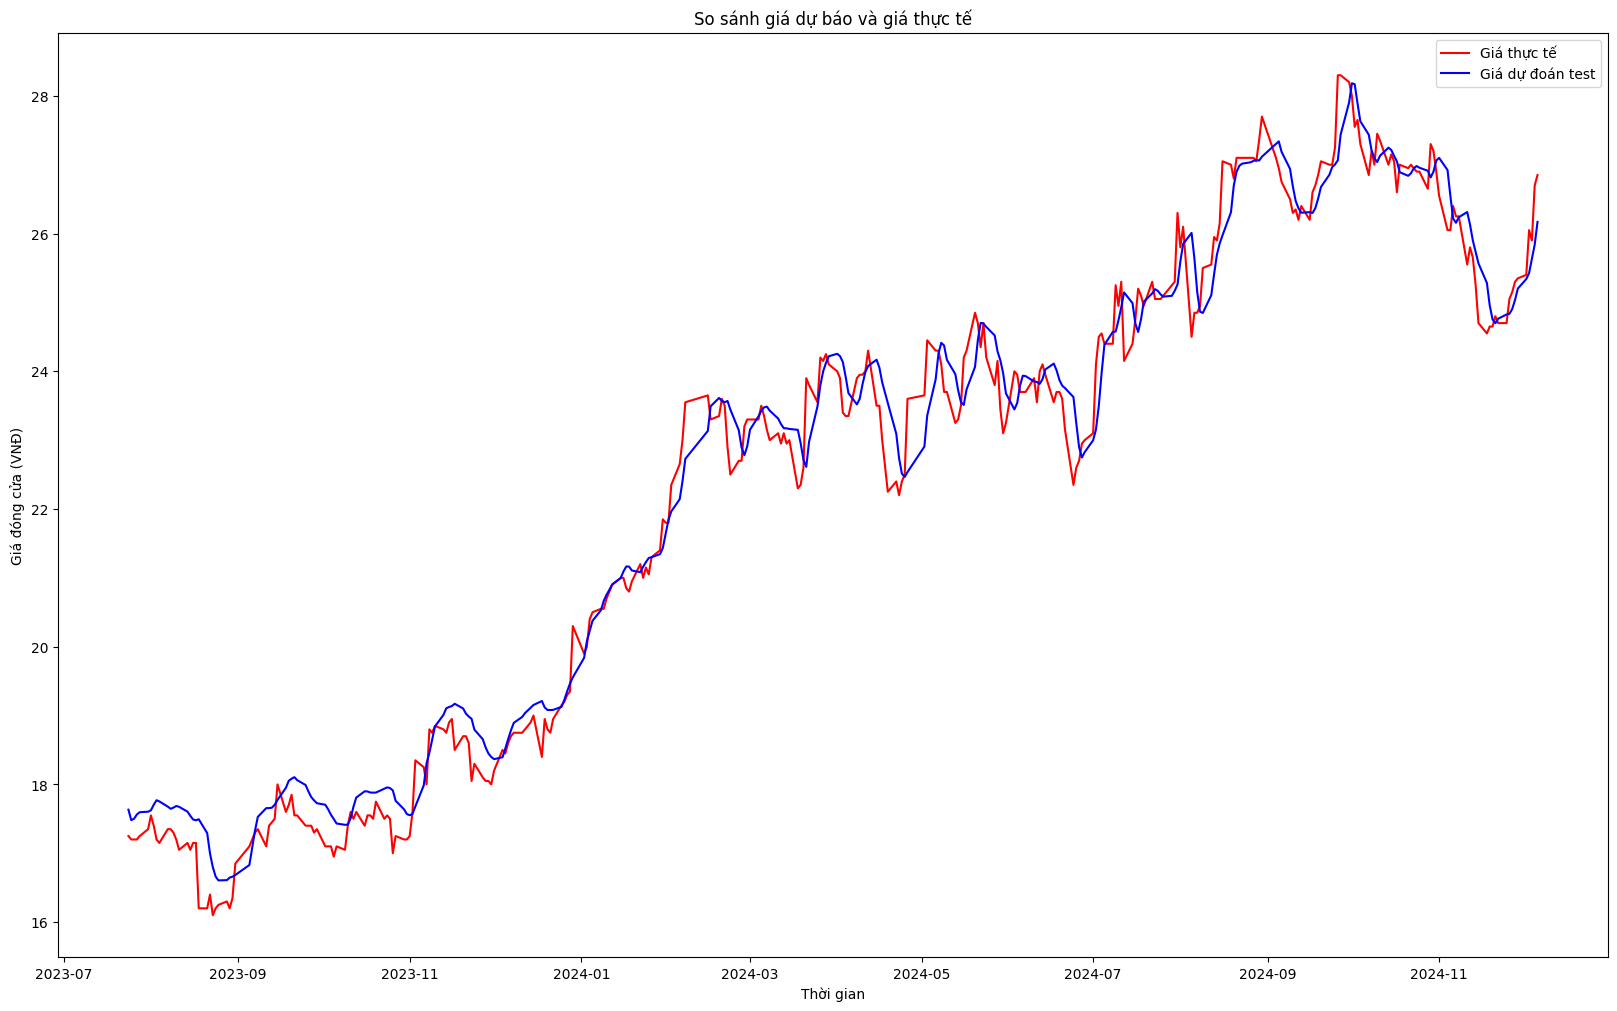

In [18]:
# Chọn dữ liệu cho test_data1
num_test_predictions = len(y_test_predict)
test_data1 = df.iloc[-num_test_predictions:].copy()
plt.figure(figsize=(20, 12))
if 'Ngay' in test_data1.columns:
    plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
else:
    raise KeyError("Cột 'Ngày' không tồn tại trong test_data1.")

test_data1 = test_data1.copy()
test_data1['Dự đoán'] = y_test_predict.flatten()
plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.title('So sánh giá dự báo và giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.show()


In [18]:
print('--- Kết quả trên tập train ---')
# R2 score
print('Độ phù hợp tập train (R2):', r2_score(y_train, y_train_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):', mean_absolute_error(y_train, y_train_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập train:', mean_absolute_percentage_error(y_train, y_train_predict) * 100)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
print('RMSE trên tập train (VNĐ):', rmse_train)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_train = np.max(y_train) - np.min(y_train)
accuracy_train = 1 - (rmse_train / range_y_train)
print('Độ chính xác trên tập train (%):', accuracy_train * 100)

# F1 Score (Chuyển thành bài toán phân loại)
error_threshold = 10  # Ngưỡng sai số
y_train_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
y_train_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
f1_train = f1_score(y_train_class, y_train_pred_class)
print('F1 Score trên tập train:', f1_train)
print("----------------------------------------------------")

--- Kết quả trên tập train ---
Độ phù hợp tập train (R2): 0.9784267328003927
Sai số tuyệt đối trung bình trên tập train (VNĐ): 0.6233931711255654
Phần trăm sai số tuyệt đối trung bình trên tập train: 2.3204786505363435
RMSE trên tập train (VNĐ): 0.9244167953655519
Độ chính xác trên tập train (%): 97.55445292231335
F1 Score trên tập train: 1.0
----------------------------------------------------


In [19]:
y_test = data[-len(y_test_predict):]

In [20]:
print('--- Kết quả trên tập test ---')
# R2 score
print('Độ phù hợp tập test (R2):', r2_score(y_test, y_test_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mean_absolute_error(y_test, y_test_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập test:', mean_absolute_percentage_error(y_test, y_test_predict) * 100)

# RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
print('RMSE trên tập test (VNĐ):', rmse_test)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_test = np.max(y_test) - np.min(y_test)
accuracy_test = 1 - (rmse_test / range_y_test)
print('Độ chính xác trên tập test (%):', accuracy_test * 100)

# F1 Score (Chuyển thành bài toán phân loại)
y_test_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
y_test_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
f1_test = f1_score(y_test_class, y_test_pred_class)
print('F1 Score trên tập test:', f1_test)
print("----------------------------------------------------")

--- Kết quả trên tập test ---
Độ phù hợp tập test (R2): 0.9842973008747066
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.35121742976194176
Phần trăm sai số tuyệt đối trung bình trên tập test: 1.6262951517349122
RMSE trên tập test (VNĐ): 0.44788109410107535
Độ chính xác trên tập test (%): 96.32884349097479
F1 Score trên tập test: 1.0
----------------------------------------------------


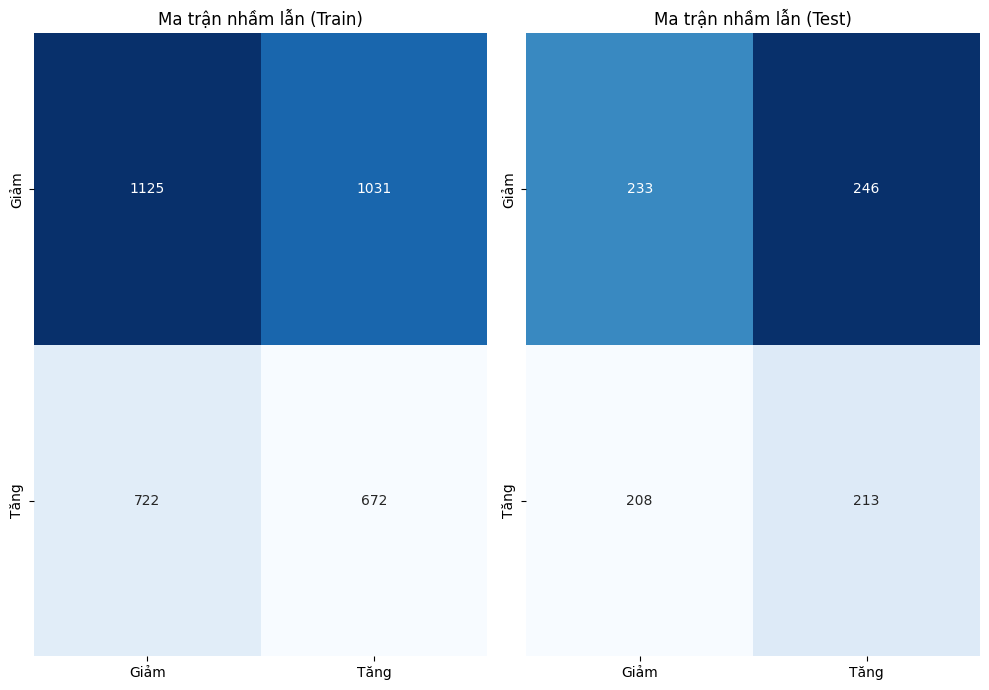

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def create_labels(data):
    return [1 if data[i] > data[i-1] else 0 for i in range(1, len(data))]

# Chuyển đổi giá trị thực tế và dự đoán thành nhãn phân loại
y_train_labels = create_labels(y_train)
y_train_predict_labels = create_labels(y_train_predict.flatten())

y_test_labels = create_labels(y_test)
y_test_predict_labels = create_labels(y_test_predict.flatten())

# Tạo ma trận nhầm lẫn cho tập train
cm_train = confusion_matrix(y_train_labels, y_train_predict_labels)
cm_test = confusion_matrix(y_test_labels, y_test_predict_labels)

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(10, 7))

# Ma trận nhầm lẫn cho tập train
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Giảm", "Tăng"], yticklabels=["Giảm", "Tăng"])
plt.title("Ma trận nhầm lẫn (Train)")

# Ma trận nhầm lẫn cho tập test
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Giảm", "Tăng"], yticklabels=["Giảm", "Tăng"])
plt.title("Ma trận nhầm lẫn (Test)")

plt.tight_layout()
plt.show()